# Anomaly detection using autoencoder based on the reconstruction error

In [100]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader

In [101]:
data = pd.read_csv('data/DSA_features.csv')
data.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1


In [102]:
data['activity'].value_counts()

activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: count, dtype: int64

In [103]:
filtering_activities = ['lyingRigh', 'lyingBack', 'jumping']
filtered_data = data[data['activity'].isin(filtering_activities)].copy()
filtered_data['abnormal'] = filtered_data['activity'].apply(lambda x: 0 if x in ['lyingRigh', 'lyingBack'] else 1)
filtered_data.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people,abnormal
960,-4.834646,-4.7185,-4.9049,0.001124,0.033529,0.632141,-0.501018,-0.41744,-0.59561,0.001016,...,0.074676,-0.532664,-0.52993,-0.53521,9.585668e-07,0.000979,-0.193301,lyingBack,p1,0
961,-4.780810,-4.5850,-4.8833,0.003948,0.062835,1.052880,-0.480601,-0.40372,-0.63184,0.001297,...,-0.181526,-0.531169,-0.52940,-0.53365,7.608973e-07,0.000872,-0.372381,lyingBack,p1,0
962,-4.804400,-4.7037,-4.8755,0.001482,0.038496,0.735226,-0.493925,-0.42616,-0.59561,0.000863,...,-0.263115,-0.530569,-0.52873,-0.53222,5.160537e-07,0.000718,0.185587,lyingBack,p1,0
963,-4.750563,-4.5696,-4.8977,0.004447,0.066683,0.710263,-0.437358,-0.30877,-0.55225,0.003587,...,-0.060925,-0.531167,-0.52962,-0.53283,4.975523e-07,0.000705,-0.145321,lyingBack,p1,0
964,-4.774916,-4.6741,-4.8457,0.001080,0.032868,0.324779,-0.459456,-0.38900,-0.53714,0.001059,...,0.335811,-0.529804,-0.52706,-0.53251,1.292131e-06,0.001137,-0.026271,lyingBack,p1,0


In [104]:
le_activity = LabelEncoder()
filtered_data['activity'] = le_activity.fit_transform(filtered_data['activity'])

le_people = LabelEncoder()
filtered_data['people'] = le_people.fit_transform(filtered_data['people'])

filtered_data.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people,abnormal
960,-4.834646,-4.7185,-4.9049,0.001124,0.033529,0.632141,-0.501018,-0.41744,-0.59561,0.001016,...,0.074676,-0.532664,-0.52993,-0.53521,9.585668e-07,0.000979,-0.193301,1,0,0
961,-4.780810,-4.5850,-4.8833,0.003948,0.062835,1.052880,-0.480601,-0.40372,-0.63184,0.001297,...,-0.181526,-0.531169,-0.52940,-0.53365,7.608973e-07,0.000872,-0.372381,1,0,0
962,-4.804400,-4.7037,-4.8755,0.001482,0.038496,0.735226,-0.493925,-0.42616,-0.59561,0.000863,...,-0.263115,-0.530569,-0.52873,-0.53222,5.160537e-07,0.000718,0.185587,1,0,0
963,-4.750563,-4.5696,-4.8977,0.004447,0.066683,0.710263,-0.437358,-0.30877,-0.55225,0.003587,...,-0.060925,-0.531167,-0.52962,-0.53283,4.975523e-07,0.000705,-0.145321,1,0,0
964,-4.774916,-4.6741,-4.8457,0.001080,0.032868,0.324779,-0.459456,-0.38900,-0.53714,0.001059,...,0.335811,-0.529804,-0.52706,-0.53251,1.292131e-06,0.001137,-0.026271,1,0,0


In [105]:
X = filtered_data.drop(['activity', 'people', 'activity'], axis=1).values
y = filtered_data['abnormal'].values
print(X.shape, y.shape)

(1440, 271) (1440,)


In [106]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train = X_scaled[y == 0]
y_train = y[y == 0]
X_test, y_test = X_scaled, y

X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

In [107]:
class DSADataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [108]:
train_dataset = DSADataset(X_train_tensor, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = DSADataset(X_test_tensor, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [109]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = X_train.shape[1]
net = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [111]:
num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    net.train()
    train_loss = 0
    train_total = 0
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        train_loss += loss.item() * inputs.size(0)
        train_total += inputs.size(0)
        
    train_losses.append(train_loss / train_total)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}')

Epoch [10/100], Train Loss: 0.1542
Epoch [20/100], Train Loss: 0.1105
Epoch [30/100], Train Loss: 0.0887
Epoch [40/100], Train Loss: 0.0727
Epoch [50/100], Train Loss: 0.0630
Epoch [60/100], Train Loss: 0.0620
Epoch [70/100], Train Loss: 0.0512
Epoch [80/100], Train Loss: 0.0480
Epoch [90/100], Train Loss: 0.0445
Epoch [100/100], Train Loss: 0.0425


In [112]:
net.eval()
with torch.no_grad():
    reconstructions = net(X_test_tensor)
    reconstruction_errors = torch.mean((reconstructions - X_test_tensor) ** 2, dim=1)

min_error = torch.min(reconstruction_errors).item()
max_error = torch.max(reconstruction_errors).item()
thresholds = np.linspace(min_error, max_error, 100)

accuracies = []

for threshold in thresholds:
    anomalies = (reconstruction_errors > threshold).float()
    accuracy = torch.sum(anomalies == torch.FloatTensor(y_test)).item() / len(y_test)
    accuracies.append(accuracy)

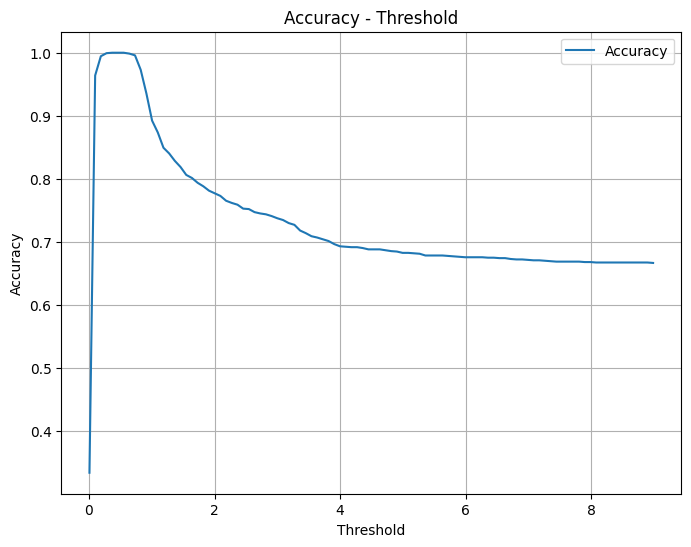

In [113]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, accuracies, label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy - Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [117]:
net.eval()
with torch.no_grad():
    reconstructions = net(X_test_tensor)
    reconstruction_errors = torch.mean((reconstructions - X_test_tensor) ** 2, dim=1)

threshold = torch.max(torch.mean((net(X_train_tensor) - X_train_tensor) ** 2, dim=1))
print("Threshold: ", threshold.item())

anomalies = (reconstruction_errors > threshold).float()
accuracy = torch.sum(anomalies == torch.FloatTensor(y_test)).item() / len(y_test)
print("Accuracy: ", accuracy)

Threshold:  0.3037167191505432
Accuracy:  1.0
